# 3. (20 points)
We are given a dataset containing various criteria important to get admissions into Master’s program and probablity of getting an admit.
Dataset is available at http://preon.iiit.ac.in/~sanjoy_chowdhury/AdmissionDataset.zip

1. Implement a model using linear regression to predict the probablity of getting the admit.(10 points)
2. Compare the performance of **Mean square error loss function** vs **Mean Absolute error function** vs **Mean absolute percentage error function** and explain the reasons for the observed behaviour.(5 points)
3. Analyse and report the behaviour of the coefficients(for example: sign of coefficients, value of coefficients etc.) and support it with appropriate plots as necessary(5 points)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.datatools import inspect_data


In [2]:
df = pd.read_csv("../data/admission/data.csv")

# we do not need Serial No. column
df.drop(['Serial No.'], axis=1, inplace=True)

# # make class label the last column 
# cols = df.columns.tolist()
# cols.remove("class")
# df = df[cols +["class"]]

# target = "label"
# # rename the column whose value is to be predicted to "label"
# df = df.rename(columns={"class": target})

df = df.rename(columns={"Chance of Admit ": "Chance of Admit"}) 

df.head(3)


,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,317,103,2,2.5,2.0,8.15,0,0.65
1,319,108,3,3.0,3.5,8.54,1,0.71
2,322,110,3,3.5,2.5,8.67,1,0.80


In [3]:
df.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit'],
      dtype='object')

In [4]:
# inspect data to get insights
inspect_data(df)
df.info()

GRE Score 49 min: 290 max: 340
------------------
TOEFL Score 29 min: 92 max: 120
------------------
University Rating 5 min: 1 max: 5
[1 2 3 4 5]
[ 28 116 144  95  67]
------------------
SOP 9 min: 1.0 max: 5.0
[1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[ 5 25 40 54 74 79 80 57 36]
------------------
LOR  9 min: 1.0 max: 5.0
[1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[ 1  9 43 47 86 83 83 55 43]
------------------
CGPA 177 min: 7.2 max: 9.92
------------------
Research 2 min: 0 max: 1
[0 1]
[201 249]
------------------
Chance of Admit 60 min: 0.34 max: 0.97
------------------
Datframe size: 450
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 8 columns):
GRE Score            450 non-null int64
TOEFL Score          450 non-null int64
University Rating    450 non-null int64
SOP                  450 non-null float64
LOR                  450 non-null float64
CGPA                 450 non-null float64
Research             450 non-null int64
Chance of Admit  

In [5]:
df.head(3)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,317,103,2,2.5,2.0,8.15,0,0.65
1,319,108,3,3.0,3.5,8.54,1,0.71
2,322,110,3,3.5,2.5,8.67,1,0.80


In [6]:
import random

def train_test_split(X, y, test_size, random_state=None):
    """Splits data into training and testing sets.
    test_size must be fractional eg 0.2 for 20% split"""

    if random_state is not None:
        # Seed to generate same pseudo-random numbers everytime to make it reproducible.
        random.seed(random_state)

    test_size = round(test_size * len(X))  # change proportion to actual number of rows

    indices = X.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    X_test = X.loc[test_indices, :]
    y_test = y.loc[test_indices] 
    X_train = X.drop(test_indices)
    y_train = y.drop(test_indices)

    return X_train, X_test, y_train, y_test


In [7]:
X = df.drop(["Chance of Admit"], axis=1)
y = df["Chance of Admit"]


In [8]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=1)

### Normalize features

In [9]:
mean = X_train.mean()
std = X_train.std()

# Normalize training data
X_train = (X_train - mean) / std

# add a column for x0 containing all Ones
X_train = X_train.assign(x0=pd.Series(np.ones(len(X_train))).values)

# TODO: make x0 the first column
columns = X_train.columns.tolist()
columns.remove('x0')
X_train = X_train[['x0'] + columns]

# Normalize validation data
X_validate = (X_validate - mean) / std

# add a column for x0 containing all Ones
X_validate = X_validate.assign(x0=pd.Series(np.ones(len(X_validate))).values)

# TODO: make x0 the first column
columns = X_validate.columns.tolist()
columns.remove('x0')
X_validate = X_validate[['x0'] + columns]


In [10]:
n = len(X_train.columns) # number of columns
# convert X and y from dataframe to numpy ndarrays
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values

y_validate = y_validate.values

# make y a vector(1d column) 
y_train = np.reshape(y_train, (len(y_train), 1))

In [11]:
def compute_cost(X, y, theta):
    """compute_cost(X, y, theta) computes the cost of using theta as the
    parameter for linear regression to fit the data points in X and y"""

    m = len(y) # number of training examples
    
    H = np.matmul(X, theta)  # H = hypothesis
    J = (1 / (2*m)) * (sum((H - y) ** 2))  # J = Cost function

    return J

In [12]:
def gradient_descent(X, y, theta, alpha, num_iters):
    """Performs gradient descent to learn theta
       theta = gradient_descent(x, y, theta, alpha, num_iters) updates theta by
       taking num_iters gradient steps with learning rate alpha
    """
    m = len(y) # number of training examples
    costs = np.zeros(num_iters)

    for it in range(num_iters):
        H = np.matmul(X, theta)
        delta = (1/m) * np.matmul(X.T , (H - y))
        
        theta = theta - (alpha * delta)
        
        costs[it] = compute_cost(X, y, theta)
        
    return theta, costs


In [13]:
theta = np.zeros((n,1))
iterations = 1000
alpha = 0.01

In [14]:
theta, costs = gradient_descent(X_train, y_train, theta, alpha, iterations)

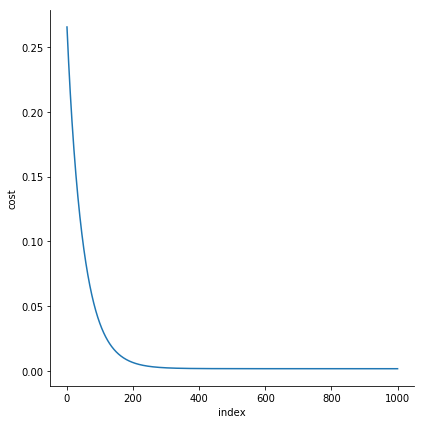

In [15]:
plotdf = pd.DataFrame(data=list(zip(range(1,len(costs)+1),costs)), columns=["index","cost"])
sns.relplot( y="cost", x="index", kind="line", data=plotdf, height=6)

In [16]:
costs[-10:-1]

array([0.00183305, 0.00183303, 0.00183301, 0.00183299, 0.00183297,
       0.00183295, 0.00183293, 0.00183291, 0.00183289])

In [17]:
# predict probabilities of X_validate data
y_pred = np.matmul(X_validate, theta)[:,0]
y_pred = np.around(y_pred, decimals=2)

In [18]:
print(y_pred[:10])
print(y_validate[:10])

[0.63 0.94 0.66 0.64 0.63 0.7  0.65 0.7  0.8  0.73]
[0.58 0.96 0.7  0.64 0.69 0.67 0.49 0.71 0.76 0.81]


In [19]:
(y_validate - y_pred)

array([-0.05,  0.02,  0.04,  0.  ,  0.06, -0.03, -0.16,  0.01, -0.04,
        0.08, -0.09,  0.  , -0.23,  0.02,  0.  ,  0.06,  0.07,  0.03,
       -0.01, -0.02, -0.02, -0.02,  0.01, -0.08,  0.06, -0.02,  0.07,
       -0.03, -0.04,  0.06, -0.01, -0.1 ,  0.05,  0.05,  0.03, -0.02,
       -0.01,  0.06,  0.08,  0.02,  0.05,  0.03, -0.02,  0.05,  0.1 ,
       -0.05,  0.01,  0.01, -0.05,  0.05, -0.03, -0.08,  0.08,  0.  ,
       -0.01,  0.04,  0.08,  0.05, -0.13, -0.13,  0.01, -0.06,  0.02,
       -0.05,  0.05, -0.05, -0.01, -0.16, -0.14,  0.02,  0.05,  0.04,
        0.02,  0.05,  0.02,  0.03,  0.  ,  0.  , -0.03, -0.1 ,  0.04,
        0.01,  0.04,  0.  ,  0.  , -0.02,  0.02,  0.04,  0.02,  0.01])

In [20]:
theta

array([[0.72299656],
       [0.02542939],
       [0.01937121],
       [0.00911127],
       [0.00206231],
       [0.01881954],
       [0.05967875],
       [0.01151891]])

In [21]:
from sklearn.metrics import r2_score
r2_score(y_validate, y_pred)

0.8154618236647706